In [2]:
#note that the adjacency matrix for a graph is a 0/1 matrix
#0/1 exists in any field, so we can view A \in (F_p)^{n^2} \cong F_{p^{n^2}} = F_q
#thus every adjacency matrix A can be viewed as an element of F_q

In [3]:
#determine if A is a 0/1 adjacency matrix with zeros on diagonal, symmetric
from sage.misc.flatten import flatten
def is_adj_matrix(A):
    #deal with case A is list of lists or matrix
    if type(A) == list:
        flat_A = flatten(A) #make the adjacency matrix into a list
        n = len(A) #get the number of columns of A
    else:
        flat_A = flatten([list(row) for row in A.rows()])
        n = A.ncols()
    zero_one = all(flat_A[k] == 0 or flat_A[k] == 1 for k in range(n^2))
    symmetric = matrix(A) == matrix(A).transpose()
    zero_diagonal = all(A[k][k] == 0 for k in range(n))
    return zero_one and symmetric and zero_diagonal

In [4]:
#given an adjacency matrix A and a prime p
#embed the graph A into F_q where q=p^{n^2} and n is the number of vertices
def graph_embedding(A,p):
    try:
        assert p in Primes() #make sure p is prime
    except AssertionError:
        print("p must be prime")
        return
    if type(A) == list:
        n = len(A) #get the number of columns of A
        flat_A = flatten(A) #make the adjacency matrix into a list
    else:
        n = A.ncols()
        flat_A = flatten([list(row) for row in A.rows()])
    q = p**(n**2) #compute q=p^{n^2}
    alpha = GF(q).gen() #get a primitive element for the finite field F_q
    try:
        assert is_adj_matrix(A) #ensure A is an adjacency matrix
    except AssertionError:
        print("A must be a 0/1 adjacency matrix")
        return
    return sum([flat_A[k]*alpha**k for k in range(n^2)]) #let {1,alpha,...,alpha^{n^2-1}} be a basis and map the matrix into F_q

In [142]:
#naively find k such that alpha^k = x 
#where alpha is a generator for the finite field
def gen_power(x):
    if x == 0:
        return float('nan')
    q = x.parent().order()
    K.<alpha> = GF(q,modulus="primitive")
    return K(x).multiplicative_order()

In [6]:
#compute all adjacency matrices
def all_adj_mats(n):
    all_zero_one_mats = [matrix(ZZ,A) for A in MatrixSpace(GF(2),n,n)] #compute all 0/1 matrices
    return [A for A in all_zero_one_mats if is_adj_matrix(A)]

In [7]:
#compute integer corresponding to adjacency matrix
def graph_int(A,p):
    return gen_power(graph_embedding(A,p))

In [8]:
#assign a unique integer to the pair (i,j) as an element of a matrix
#count number of elements to right of diagonal until you reach (i,j)
def unique_int_pair(n,i,j):
    return sum(n-k for k in range(1,i)) + (j-i)

In [9]:
#compute the integer corresponding to a labeled graph given as an adjacency matrix A
def graph_int_basic(A):
    try:
        assert is_adj_matrix(A)
    except AssertionError:
        print("A must be 0/1 adjacency matrix")
    if type(A) == list:
        flat_A = flatten(A) #make the adjacency matrix into a list
        n = len(A) #get the number of columns of A
    else:
        n = A.ncols()
        flat_A = flatten([list(row) for row in A.rows()])
    return sum(flatten([[A[i][j]*(2**unique_int_pair(n,i+1,j+1)) for j in range(i+1,n)] for i in range(n)]))

In [10]:
#compute the basic graph integer k and a generator for F_q alpha and compute alpha^k
def graph_embedding_basic(A,p):
    try:
        assert is_adj_matrix(A)
    except AssertionError:
        print("A must be 0/1 adjacency matrix")
    if type(A) == list:
        flat_A = flatten(A) #make the adjacency matrix into a list
        n = len(A) #get the number of columns of A
    else:
        n = A.ncols()
        flat_A = flatten([list(row) for row in A.rows()])
    #ensure the cyclic group of size q-1 is at least as big as the number of graphs, 2^((n choose 2)+1)
    r = 1
    while p**r - 1 < 2**(binomial(n,2)+1):
        r += 1
    q = p**r
    k = graph_int_basic(A)
    K.<alpha> = GF(q,modulus="primitive") #find a primitive generator of the multiplicative group of F_q
    return alpha**k

In [11]:
#define the action of the symmetric group on graphs
#sigma is an element of the symmetric group, A is an adjacency matrix
#returns sigma*A
def sym_act(sigma,A):
    try:
        assert is_adj_matrix(A)
    except AssertionError:
        print("A must be 0/1 adjacency matrix")
    if type(A) == list:
        A = matrix(A) #get the number of columns of A
    n = A.ncols()
    try:
        assert sigma in SymmetricGroup(n)
    except AssertionError():
        print("sigma must be an element of the symmtric group")
    return sigma.matrix()*A*sigma.matrix().transpose()

In [12]:
#define function which hides the automorphism group of the adjacency matrix A
#the output is an adjacency matrix embedded into a finite field
def f_int(A,sigma):
    return graph_int_basic(sym_act(sigma,A))

In [13]:
#return the graph embedding of sigma*A
def f_embed(A,sigma,p):
    return graph_embedding_basic(sym_act(sigma,A),p)

In [143]:
#compute the dft of a function f
def fourier_transform(f,p):
    n = 1
    while factorial(n) < len(f):
        n += 1
    sga_dft = SymmetricGroup(n).algebra(GF(p)).dft() #compute DFT of symmetric group algebra
    return sga_dft*vector(f)

In [14]:
#compute the Fourier coefficients of f: S_n --> F_q using the SGA DFT
def fourier_coefficients(A,p):
    if type(A) == list:
        A = matrix(A)
    n = A.ncols()
    sga_dft = SymmetricGroup(n).algebra(GF(p)).dft() #compute DFT of symmetric group algebra
    f_list = [f_embed(A,sigma,p) for sigma in SymmetricGroup(n)] #compute f for all elements
    return sga_dft*vector(f_list)

In [15]:
#generate a random adjacency matrix on n vertices
def random_adj_mat(n):
    A = [[0 for j in range(n)] for i in range(n)]
    for i in range(n):
        for j in range(i+1,n):
            A[i][j] = int(GF(2).random_element())
    return matrix(A) + matrix(A).transpose()

In [69]:
n=5; p=7

In [157]:
A = random_adj_mat(n); A

[0 0 1 1 0]
[0 0 0 0 0]
[1 0 0 0 1]
[1 0 0 0 0]
[0 0 1 0 0]

In [158]:
graph_int_basic(A)

524

In [159]:
graph_embedding_basic(A,p)

3*alpha^3 + 6*alpha^2 + 4

In [172]:
import matplotlib.pyplot as plt
sym_group_index = [str(sigma) for sigma in SymmetricGroup(n)]
#f_int_list = [f_int(A,sigma) for sigma in SymmetricGroup(n)]
#f_int_list = [10 for sigma in SymmetricGroup(n)]
f_int_list = [sigma.matrix().trace() for sigma in SymmetricGroup(n)]
#f_int_list = [(SymmetricGroup(n)[7]*sigma).matrix().trace() for sigma in SymmetricGroup(n)]

In [173]:
f_int_list

[5,
 0,
 3,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 3,
 0,
 1,
 0,
 3,
 1,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 1,
 1,
 0,
 1,
 1,
 2,
 1,
 1,
 2,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 3,
 2,
 1,
 1,
 2,
 0,
 3,
 1,
 2,
 0,
 0,
 3,
 1,
 1,
 0,
 0,
 2,
 0,
 1,
 0,
 2,
 1,
 0,
 0,
 3,
 0,
 2,
 2,
 1,
 0,
 1,
 2,
 2,
 0,
 0,
 1,
 3,
 0,
 2,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 3,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 3,
 0,
 2,
 1,
 1,
 1,
 2,
 0,
 0,
 0]

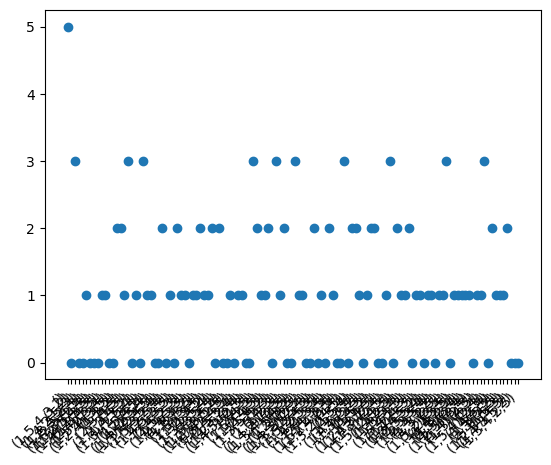

In [174]:
plt.xticks(rotation=45, ha="right")
plt.scatter(sym_group_index,f_int_list)

In [175]:
fourier_transform(f_int_list,p)

(1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)

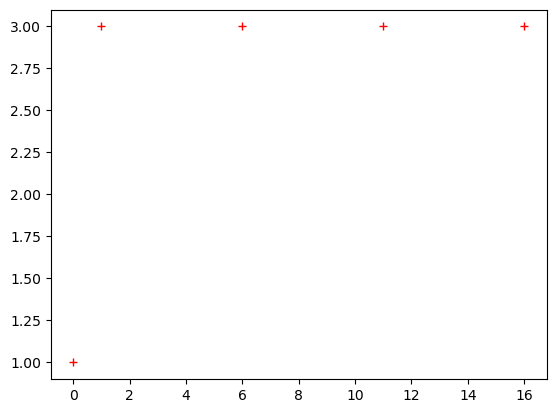

In [176]:
plt.plot([gen_power(x) for x in fourier_transform(f_int_list,p)],'r+')

In [156]:
fourier_coefficients(A,p)

(3*alpha^3 + 3*alpha^2 + alpha + 4, alpha^3 + 2*alpha^2 + 5*alpha + 2, 4*alpha^3 + alpha^2 + 6*alpha + 1, 6*alpha^2 + 5, alpha^2 + 2, 4*alpha^3 + 4*alpha^2 + 3*alpha, 2*alpha^3 + 2*alpha^2 + 5*alpha, 6*alpha^3 + 2*alpha + 2, alpha^3 + 5*alpha + 5, alpha^2 + 5*alpha + 1, 4*alpha^2 + 6*alpha + 4, 5*alpha^3 + 6*alpha^2 + 6*alpha + 3, 2*alpha^3 + alpha^2 + alpha + 4, alpha^3 + alpha^2 + 2*alpha + 2, 4*alpha^3 + 4*alpha^2 + alpha + 1, 3*alpha^3 + 5*alpha + 2, 4*alpha^3 + 2*alpha + 5, 4*alpha^3 + 5*alpha^2 + 4*alpha + 4, 2*alpha^3 + 6*alpha^2 + 2*alpha + 2, 2*alpha^3 + 6*alpha^2 + 2*alpha + 2, alpha^3 + 3*alpha^2 + alpha + 1, 3*alpha^3 + alpha^2 + 2*alpha + 1, 2*alpha^3 + 5*alpha^2 + 1, alpha^3 + 6*alpha^2 + 4, alpha^3 + 6*alpha^2 + 4, 4*alpha^3 + 3*alpha^2 + 2, 3*alpha^3 + 2*alpha^2 + 6*alpha + 1, 5*alpha^3 + 3*alpha + 1, 6*alpha^3 + 5*alpha + 4, 6*alpha^3 + 5*alpha + 4, 3*alpha^3 + 6*alpha + 2, 2*alpha^3 + 3*alpha^2 + 5*alpha + 6, 2*alpha^3 + 2*alpha^2 + 5*alpha + 6, alpha^3 + alpha^2 + 6*

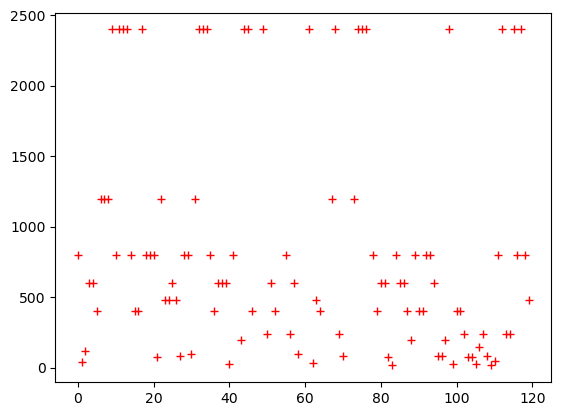

In [170]:
plt.plot([gen_power(x) for x in fourier_coefficients(A,p)],'r+')

(array([12., 12., 11., 16.,  9.,  8., 12., 13., 15., 12.]),
 array([  17. ,  251.6,  486.2,  720.8,  955.4, 1190. , 1424.6, 1659.2,
        1893.8, 2128.4, 2363. ]),
 <BarContainer object of 10 artists>)

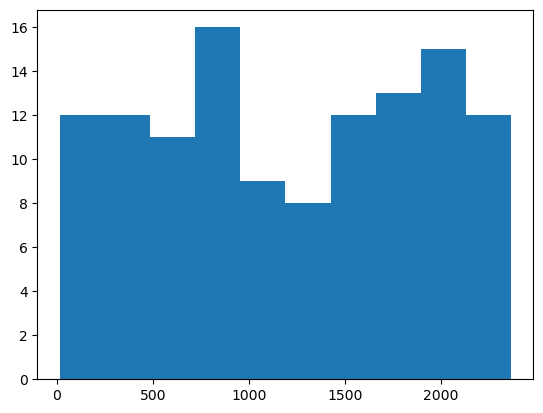

In [118]:
plt.hist([gen_power(x) for x in fourier_coefficients(A,p)])